In [1]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
# import plotly.express as px
#from plotly.offline import init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, LeakyReLU, Reshape, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.models import load_model
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
print("START  ")

2023-05-17 23:12:40.945592: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


START  


In [2]:
os.getcwd()
import tensorflow as tf
tf.config.list_physical_devices('GPU')


2023-05-17 23:12:47.422256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-17 23:12:47.445197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-17 23:12:47.445367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Found 10000 images belonging to 1 classes.


(64, 128, 128, 3)

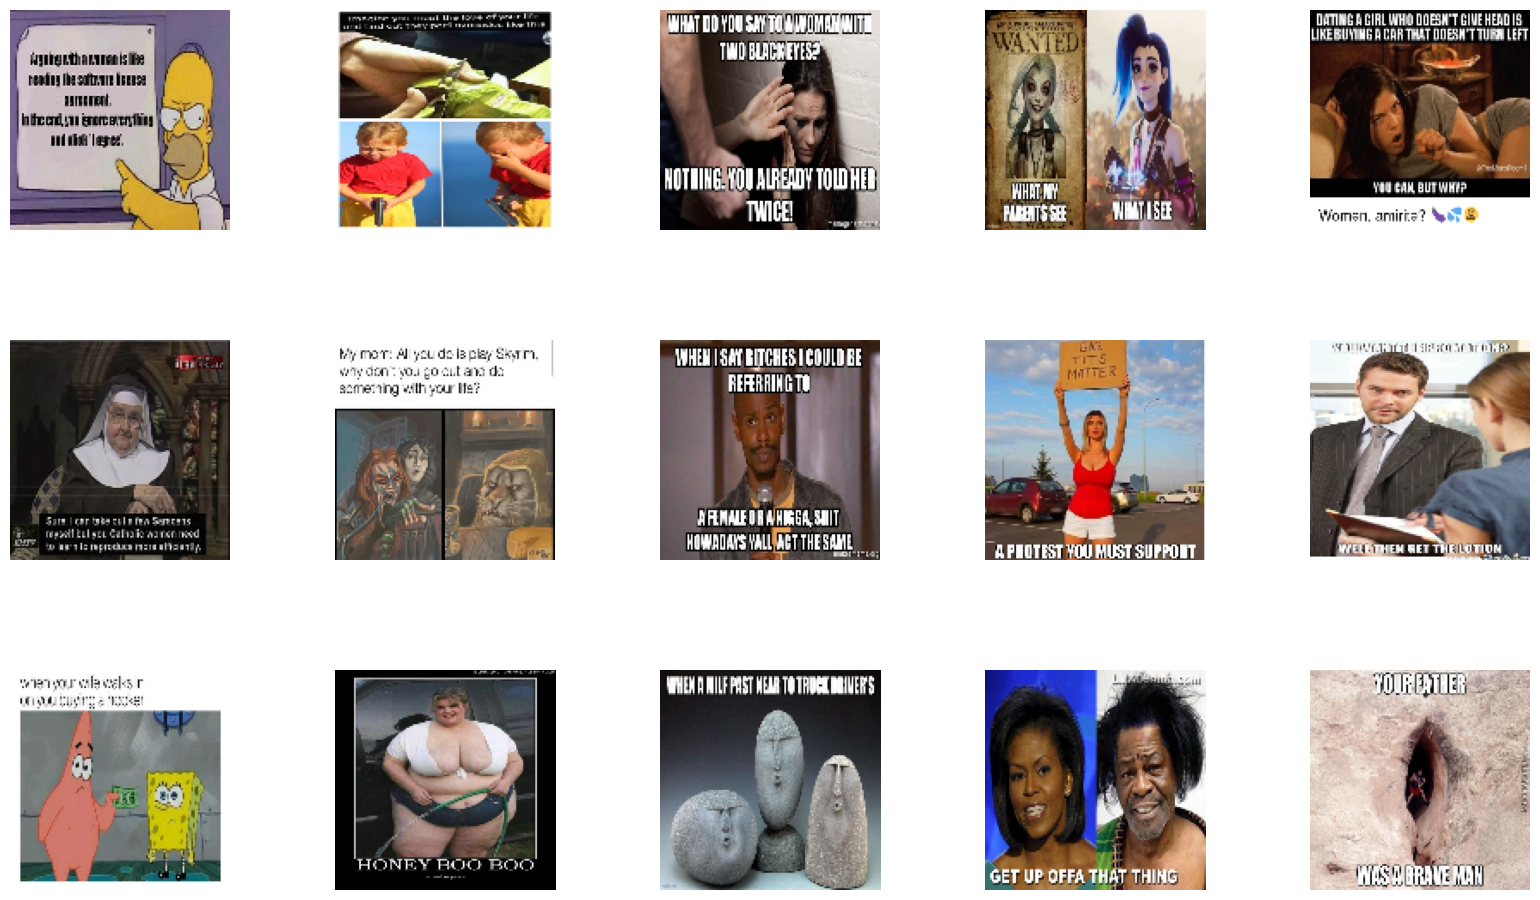

In [3]:
img_size = 128
batch_size = 64

#scale between -1 and +1
def scaling(x):
    x = (x-127.5)/127.5 
    return x
data_dir ='/home/nitesh/Documents/MY_THESIS/MAMI'
classes = ['TRAINING']
datagen = ImageDataGenerator(preprocessing_function=scaling)

data_generator = datagen.flow_from_directory(directory=data_dir,
                                        target_size=(img_size,img_size),
                                        class_mode=None,
                                        batch_size=batch_size,
                                        classes=classes,
                                        shuffle=True)

samples = data_generator.samples


images = data_generator.__next__()

plt.figure(figsize = (20 , 20))
for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow((images[i]+1)/2)
    plt.axis('off')
images.shape

In [15]:
latent_dim = 128

generator = Sequential(
    [
        Input(shape=(latent_dim,)),
        Dense(4 * 4 * 128),
        Reshape((4, 4, 128)),
        Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh"),
    ],
    name="generator",
)


generator.summary()
discriminator = Sequential(
    [
        Input(shape=(128, 128, 3)),
        Conv2D(64, kernel_size=5, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2D(128, kernel_size=5, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(0.2),
        Conv2D(256, kernel_size=5, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(0.2),
        Conv2D(256, kernel_size=5, strides=2, padding="same"),
        BatchNormalization(),
        LeakyReLU(0.2),
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 2048)              264192    
                                                                 
 reshape_5 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_28 (Conv2D  (None, 8, 8, 256)        524544    
 Transpose)                                                      
                                                                 
 batch_normalization_43 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_43 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_29 (Conv2D  (None, 16, 16, 128)      52

In [5]:
#Load generator and discriminator h5 files
# def load_models(epoch):
#     print(f"Loading Mis_Generator_{epoch}.h5" )
#     generator = load_model(f"Mis_Generator_{epoch}.h5")
#     discriminator = load_model(f"Mis_Discriminator_{epoch}.h5")
#     return generator, discriminator

In [16]:
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
dis_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy()
steps_per_epoch = int(-(samples/-batch_size))
discriminator_losses = []
generator_losses = []

disc_losses = []
gen_losses = []

In [17]:
!pip install tqdm
from tqdm import tqdm


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Epoch:  1


100%|█████████████████████████████████████████| 157/157 [00:39<00:00,  3.99it/s]


Epoch: 1 Generator Loss: 13.289849281311035 Discriminator Loss: 0.03870056942105293
Epoch:  2


100%|█████████████████████████████████████████| 157/157 [00:39<00:00,  3.93it/s]


Epoch: 2 Generator Loss: 14.357428550720215 Discriminator Loss: 0.01937367022037506
Epoch:  3


100%|█████████████████████████████████████████| 157/157 [00:40<00:00,  3.87it/s]


Epoch: 3 Generator Loss: 14.713220596313477 Discriminator Loss: 0.012915830127894878
Epoch:  4


100%|█████████████████████████████████████████| 157/157 [00:40<00:00,  3.89it/s]


Epoch: 4 Generator Loss: 14.89111614227295 Discriminator Loss: 0.009686963632702827
Epoch:  5


100%|█████████████████████████████████████████| 157/157 [00:41<00:00,  3.75it/s]


Epoch: 5 Generator Loss: 14.997854232788086 Discriminator Loss: 0.00774963665753603


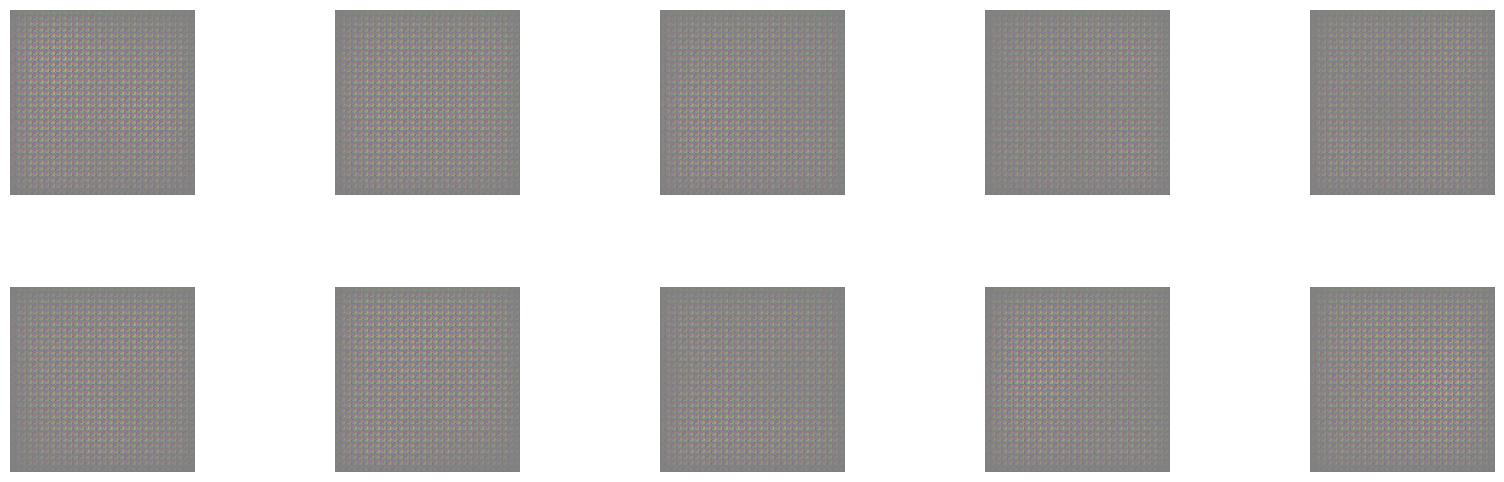

Epoch:  6


100%|█████████████████████████████████████████| 157/157 [00:40<00:00,  3.89it/s]


Epoch: 6 Generator Loss: 15.069012641906738 Discriminator Loss: 0.006458087358623743
Epoch:  7


100%|█████████████████████████████████████████| 157/157 [00:40<00:00,  3.86it/s]


Epoch: 7 Generator Loss: 15.119853019714355 Discriminator Loss: 0.005535523407161236
Epoch:  8


100%|█████████████████████████████████████████| 157/157 [00:40<00:00,  3.90it/s]


Epoch: 8 Generator Loss: 15.15809440612793 Discriminator Loss: 0.0048436010256409645
Epoch:  9


100%|█████████████████████████████████████████| 157/157 [00:40<00:00,  3.90it/s]


Epoch: 9 Generator Loss: 15.187837600708008 Discriminator Loss: 0.004305441863834858
Epoch:  10


100%|█████████████████████████████████████████| 157/157 [00:40<00:00,  3.87it/s]


Epoch: 10 Generator Loss: 15.211631774902344 Discriminator Loss: 0.00387491169385612


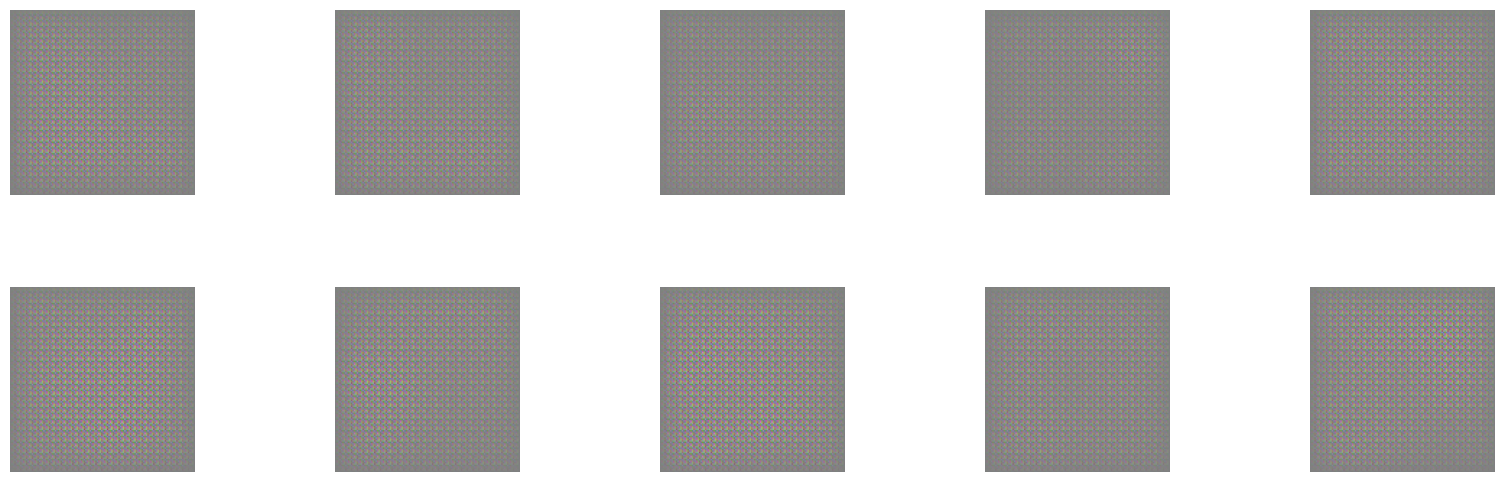

Epoch:  11


100%|█████████████████████████████████████████| 157/157 [00:40<00:00,  3.87it/s]


Epoch: 11 Generator Loss: 15.231100082397461 Discriminator Loss: 0.0035226617474108934
Epoch:  12


 20%|████████▎                                 | 31/157 [00:08<00:32,  3.85it/s]


KeyboardInterrupt: 

In [18]:

start_epochs=1
end_epochs=20

#generator, discriminator = load_models((start_epochs-1))


#Dont Train and load start_epochs 184
#############################################################################
for epoch in range(start_epochs, end_epochs+1):
    print("Epoch: ",epoch)
    
    for idx, (real) in enumerate(tqdm(data_generator)):
        if idx > steps_per_epoch:
            break
        
        batch_size = real.shape[0]
        random_latent_vectors = tf.random.normal(shape = (batch_size, latent_dim))
        fake = generator(random_latent_vectors)

        with tf.GradientTape() as d_tape:
            loss_disc_real = loss_fn(tf.ones((batch_size, 1)), discriminator(real))
            loss_disc_fake = loss_fn(tf.zeros((batch_size, 1)), discriminator(fake))
            loss_disc = (loss_disc_real + loss_disc_fake)/2
            disc_losses.append(loss_disc)

        grads = d_tape.gradient(loss_disc, discriminator.trainable_weights)
        dis_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

        with tf.GradientTape() as g_tape:
            fake = generator(random_latent_vectors)
            output = discriminator(fake)
            loss_gen = loss_fn(tf.ones(batch_size, 1), output)
            gen_losses.append(loss_gen)

        grads = g_tape.gradient(loss_gen, generator.trainable_weights)
        gen_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    
    mean_disc_loss = sum(disc_losses)/len(disc_losses)
    mean_gen_loss = sum(gen_losses)/len(gen_losses)
    
    print(f"Epoch: {epoch} Generator Loss: {mean_gen_loss} Discriminator Loss: {mean_disc_loss}")
    data_generator.on_epoch_end()
    discriminator_losses.append(mean_disc_loss)
    generator_losses.append(mean_gen_loss)
    if epoch % 5 == 0:
        random_latent_vectors = tf.random.normal(shape = (10, latent_dim))
        fake = generator(random_latent_vectors)
        generated_images = fake.numpy()
        plt.figure(figsize = (20 , 6))
        for i in range(10):
            plt.subplot(2 , 5, i+1)
            plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
            image = generated_images[i]
            plt.imshow((image+1)/2)
            plt.axis('off')
        #plt.savefig(f'Mis_generated_images_epoch_{epoch}.png')  # Save the plot
        plt.show()
    #generator.save(f"Mis_Generator_{epoch}.h5")
    #discriminator.save(f"Mis_Discriminator_{epoch}.h5")

In [ ]:

plt.figure(figsize = (20 , 20))
for i in range(10):
    plt.subplot(6 , 5, i+1)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow((fake[i]+1)/2)
    plt.title(f"Index: {i}")
    plt.axis('off')
plt.savefig(f'Final_Sample_images_after_{epoch}.png')
        


# References:

https://www.kaggle.com/code/quadeer15sh/introduction-to-dc-gans-face-generation/notebook